# Regression Evaluation

This notebook evaluates the unvalidated regression experiments.

In [1]:
import os
import pickle
import json
from typing import Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dotenv import load_dotenv

import utilities.plotting as plots
import utilities.preprocess_raw_data as prep_data
import utilities.generate_regression_dataset as gen_reg
import utilities.train_regression_model as train_reg
import utilities.latex_figures as latex_figs

In [2]:
SAVE_FIGS = True

In [3]:
load_dotenv()
EXPERIMENT = os.environ.get("EXPERIMENT_NUMBER")
print(f"The experiment number is {EXPERIMENT}")

The experiment number is 10


## Input Data Evaluation

Finding a good example device from our test dataset:

In [4]:
test_df_5 = pd.read_parquet(f"./data/experiment_datasets/experiment_{EXPERIMENT}/regression/pred_hor=5.test.parquet")

In [5]:
test_devices = test_df_5["device_uuid"].unique().tolist()

### Augmentation Effects on the Dataset

In [6]:
raw_df = pd.read_parquet("./data/my_datasets/raw_merged.parquet")

In [7]:
base_df = prep_data.load_base_dataset(raw_merged_df=raw_df)

In [8]:
test_base_df = base_df[base_df["device_uuid"].isin(test_devices)]

In [9]:
test_base_df["device_uuid"].unique()

array(['09f3fdca-6cea-4471-8d80-c6dd19f46dae',
       '0a66076f-2ef2-4b02-a856-646e09e1ee44',
       '283f7d72-8dd6-4b5e-b9c1-7d64f9316520',
       '2ed3d1f6-526d-49a6-89d2-cab6b60ea10b',
       '339a06ea-60e2-4972-9dcf-8a0a8b0828b5',
       '5544bb14-e08a-42e1-b020-11fc922bff34',
       '5b5a9733-8a66-47ec-b87c-c363a8623c74',
       '5ee55295-f9c2-4797-bd7e-bc96f79f063b',
       '630a0b86-721a-468d-9d01-5178e8a7d651',
       '6be265cf-8a44-42e8-89ed-3f955885e26c',
       '7209a801-d559-4a88-97b6-260256494b5e',
       'a4bc8c85-3d4d-48ad-ae0a-a964770aedcb',
       'cac585df-007e-4b01-a751-f7f24bbd23e3',
       'dacc4724-d859-467d-87d5-a4fba9686c9f',
       'e36e476c-a5c3-4f61-9611-bbb11af5208f',
       'f5db1fdb-672a-4065-bc48-63ad32f39264',
       'f8622f99-8e40-4107-9bd6-32085ff7afed'], dtype=object)

In [10]:
plots.plot_cycles(test_base_df, grouped_by_device=True)

In [11]:
EXAMPLE_DEV = "00082fe6-1ce0-43a0-ae8b-f42a36f5b2cc"

In [12]:
plots.plot_device(base_df, EXAMPLE_DEV)

In [13]:
raw_df = raw_df[raw_df["device_uuid"] == EXAMPLE_DEV]

In [14]:
base_df = prep_data.load_base_dataset(raw_merged_df=raw_df)

In [15]:
aug_noise_5 = prep_data.load_base_dataset(
    raw_merged_df=raw_df, add_noise=True, max_noise=5
)
aug_noise_10 = prep_data.load_base_dataset(
    raw_merged_df=raw_df, add_noise=True, max_noise=10
)
aug_noise_20 = prep_data.load_base_dataset(
    raw_merged_df=raw_df, add_noise=True, max_noise=20
)

In [16]:
aug_time_warp_05 = prep_data.load_base_dataset(
    raw_merged_df=raw_df,
    random_warp_status_times=True,
    random_max_time_warp_percent=0.5,
)
aug_time_warp_1 = prep_data.load_base_dataset(
    raw_merged_df=raw_df,
    random_warp_status_times=True,
    random_max_time_warp_percent=1.0,
)
aug_time_warp_2 = prep_data.load_base_dataset(
    raw_merged_df=raw_df,
    random_warp_status_times=True,
    random_max_time_warp_percent=2.0,
)

In [17]:
aug_fixed_time_shifting_02 = prep_data.load_base_dataset(
    raw_merged_df=raw_df, fixed_warp_status_times=True, fixed_warping_percent=0.2
)
aug_fixed_time_shifting_neg02 = prep_data.load_base_dataset(
    raw_merged_df=raw_df, fixed_warp_status_times=True, fixed_warping_percent=-0.2
)

In [18]:
plots.plot_compare_multiple_dfs(
    [
        (raw_df, "battery_level_percent", EXAMPLE_DEV, "raw", True),
        (base_df, "battery_level_percent", EXAMPLE_DEV, "preprocessed", True),
        (aug_noise_5, "battery_level_percent", EXAMPLE_DEV, "5% noise", True),
        (aug_noise_10, "battery_level_percent", EXAMPLE_DEV, "10% noise", True),
        (aug_noise_20, "battery_level_percent", EXAMPLE_DEV, "20% noise", True),
        (
            aug_time_warp_05,
            "battery_level_percent",
            EXAMPLE_DEV,
            "up to 50% random time warping",
            True,
        ),
        (
            aug_time_warp_1,
            "battery_level_percent",
            EXAMPLE_DEV,
            "up to 100% random time warping",
            True,
        ),
        (
            aug_time_warp_2,
            "battery_level_percent",
            EXAMPLE_DEV,
            "up to 200% random time warping",
            True,
        ),
        # (
        #     aug_fixed_time_shifting_02,
        #     "battery_level_percent",
        #     EXAMPLE_DEV,
        #     "+20% fixed time shifting",
        #     True,
        # ),
        # (
        #     aug_fixed_time_shifting_neg02,
        #     "battery_level_percent",
        #     EXAMPLE_DEV,
        #     "-20% fixed time shifting",
        #     True,
        # ),
    ]
)

These are the cycles extracted from our example device:

In [19]:
plots.plot_cycles(base_df)

### Input Feature Correlation

In [20]:
reg_df = gen_reg.base_to_regression_dataset(base_df)

Dropped 0 rows in 0 cycles.
4 cycles left.


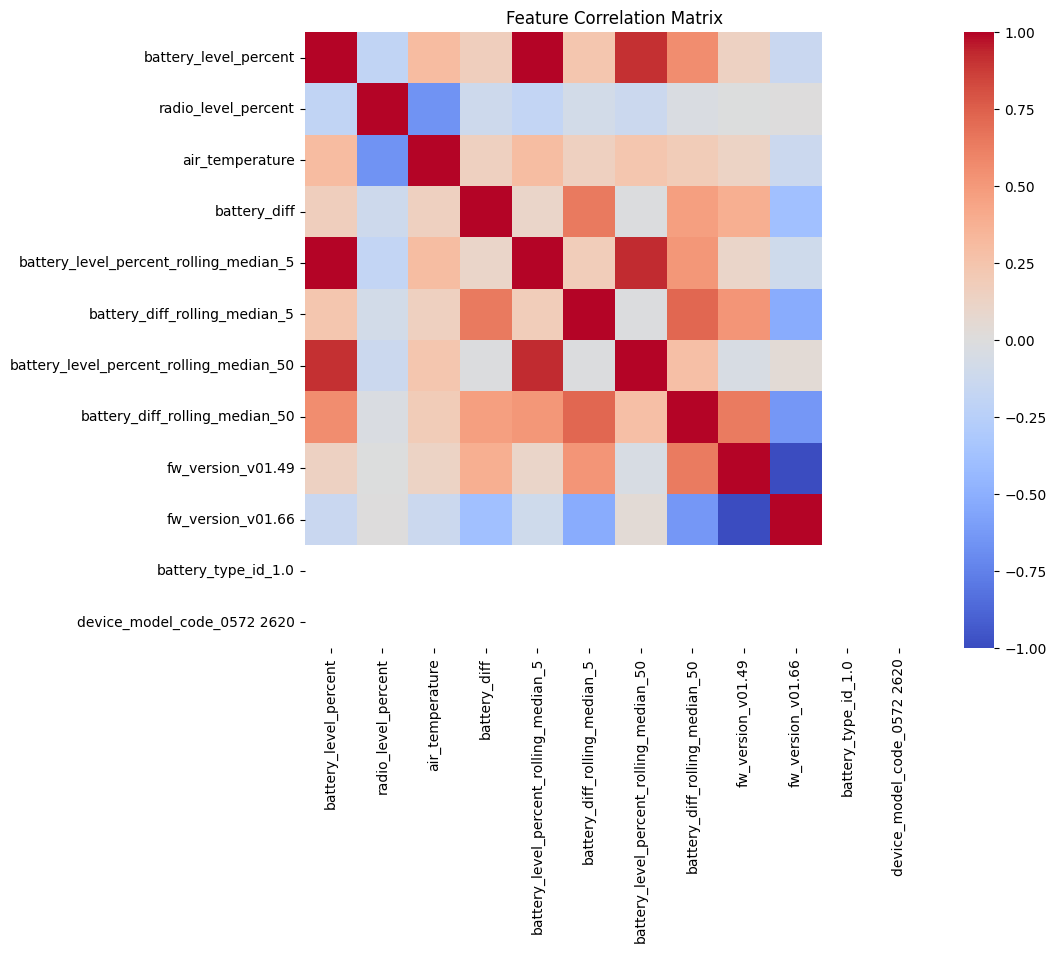

In [21]:
plt.figure(figsize=(10, 8))
correlation_matrix = reg_df.drop(
    columns=[
        "status_time",
        "device_uuid",
        "cycle_id",
        "target",
    ],
).corr()
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

#### Comparing the battery level to the rolling medians

In [22]:
plots.plot_compare_multiple_dfs(
    [
        (reg_df, "battery_level_percent", EXAMPLE_DEV, "battery_level_percent", True),
        (
            reg_df,
            "battery_level_percent_rolling_median_5",
            EXAMPLE_DEV,
            "battery_level_percent_rolling_median_5",
            True,
        ),
        (
            reg_df,
            "battery_level_percent_rolling_median_50",
            EXAMPLE_DEV,
            "battery_level_percent_rolling_median_50",
            True,
        ),
    ]
)

#### Comparing the battery difference to the rolling medians

In [23]:
plots.plot_compare_multiple_dfs(
    [
        (reg_df, "battery_diff", EXAMPLE_DEV, "battery_diff", True),
        (
            reg_df,
            "battery_diff_rolling_median_5",
            EXAMPLE_DEV,
            "battery_diff_rolling_median_5",
            True,
        ),
        (
            reg_df,
            "battery_diff_rolling_median_50",
            EXAMPLE_DEV,
            "battery_diff_rolling_median_50",
            True,
        ),
    ],
    fixed_y_axis=False,
)

## Model Evaluation

### Modell Performance Evaluation

#### Effect of Augmentation on the Model Performance

In [24]:
runs_df= pd.read_csv(f"./data/runs/reg_runs_{EXPERIMENT}.csv")
runs_df["params.n_aug"] = runs_df["params.n_aug"].astype(str)

To evaluate the model performance we will focus on the Mean Divergence Time (MDT) metric.

It is defined as follows:

The mean time for a models until the distance between its prediction curve and the target curve is 5% for at least 3 days.

So the higher the MDT the better.

Below we can see the best models, grouped by the number of devices used in the training.

We can see, that the best models always perform best when they used augmented data for the training.

In [25]:
def print_best_n_models(runs_df: pd.DataFrame, n_lines_to_print: int):
    metric_to_name = {
        "metrics.mdt": "MDT",
        "metrics.med_dt": "MedDT",
    }

    pd.options.display.float_format = "{:.1f}".format

    for n_dev in sorted(runs_df["params.n_dev"].unique()):
        print("#####################################################")
        print(f"Best models for {n_dev} devices:")
        print("#####################################################")
        for by_metric in metric_to_name.keys():
            interesting_columns = [
                "params.model_class",
                "params.n_aug",
                "params.pred_hor",
                "metrics.mdt",
                "metrics.med_dt",
                "metrics.std",
            ]

            if by_metric == "metrics.med_dt":
                runs_df.sort_values(by=["metrics.std"], ascending=True, inplace=True)
            runs_df.sort_values(by=[by_metric], ascending=False, inplace=True)

            print("-----------------")
            print(f"By metric {metric_to_name[by_metric]}:")
            print("-----------------")

            best_n = (
                runs_df[(runs_df["params.n_dev"] == n_dev)][interesting_columns]
                .head(n_lines_to_print)
                .reset_index(drop=True)
            )

            map = {col: col.split(".")[1] for col in interesting_columns}
            map[by_metric] = map[by_metric].upper()

            print(
                best_n.rename(
                    mapper=map,
                    axis="columns",
                )
            )
            print()
            try:
                best_aug_metric = best_n[best_n["params.n_aug"] != "0"][by_metric].values[0]
                best_no_aug = (
                    runs_df[
                        (runs_df["params.n_dev"] == n_dev)
                        & (runs_df["params.n_aug"] == "0")
                    ][interesting_columns]
                    .head(1)
                    .reset_index(drop=True)
                )
                if all(best_n["params.n_aug"] != "0"):
                    print("Best model with no augmentation:")
                    print(
                        best_no_aug.rename(
                            mapper=map,
                            axis="columns",
                        )
                    )
            except IndexError:
                best_aug = runs_df[(runs_df["params.n_aug"] != "0") & (runs_df["params.n_dev"] == n_dev)].sort_values(by=[by_metric], ascending=False)[interesting_columns].head(1)
                best_aug_metric = best_aug[by_metric].values[0]
                print("Best model with augmentation:")
                print(
                    best_aug.rename(
                        mapper=map,
                        axis="columns",
                    )
                )
                

            best_no_aug_metric = best_no_aug[by_metric].values[0]
            print()
            improvement = best_aug_metric - best_no_aug_metric
            improvement_percent = improvement / best_no_aug_metric * 100
            print(
                f"{metric_to_name[by_metric]} improvement through augmentation: {improvement:.1f} ({improvement_percent:.1f}%)"
            )
            print()

In [26]:
print_best_n_models(runs_df, 5)

#####################################################
Best models for 10 devices:
#####################################################
-----------------
By metric MDT:
-----------------
             model_class n_aug  pred_hor  MDT  med_dt  std
0       LinearRegression     3         1 39.2    21.0 43.4
1       LinearRegression     1         1 38.4    26.0 37.6
2       LinearRegression     3         1 37.8    21.0 41.4
3  DecisionTreeRegressor     5         1 37.7    25.0 37.0
4       LinearRegression     3         1 37.6    21.0 41.4

Best model with no augmentation:
    model_class n_aug  pred_hor  MDT  med_dt  std
0  XGBRegressor     0         1 36.7    25.0 34.3

MDT improvement through augmentation: 2.5 (6.9%)

-----------------
By metric MedDT:
-----------------
        model_class n_aug  pred_hor  mdt  MED_DT  std
0  LinearRegression     1         1 35.4    27.5 28.6
1  LinearRegression     1         1 33.8    27.5 24.6
2  LinearRegression     1         1 32.8    26.5 24.5
3  Li

In [27]:
print_best_n_models(runs_df, 2)

#####################################################
Best models for 10 devices:
#####################################################
-----------------
By metric MDT:
-----------------
        model_class n_aug  pred_hor  MDT  med_dt  std
0  LinearRegression     3         1 39.2    21.0 43.4
1  LinearRegression     1         1 38.4    26.0 37.6

Best model with no augmentation:
    model_class n_aug  pred_hor  MDT  med_dt  std
0  XGBRegressor     0         1 36.7    25.0 34.3

MDT improvement through augmentation: 2.5 (6.9%)

-----------------
By metric MedDT:
-----------------
        model_class n_aug  pred_hor  mdt  MED_DT  std
0  LinearRegression     1         1 35.4    27.5 28.6
1  LinearRegression     1         1 33.8    27.5 24.6

Best model with no augmentation:
    model_class n_aug  pred_hor  mdt  MED_DT  std
0  XGBRegressor     0         1 36.7    25.0 34.3

MedDT improvement through augmentation: 2.5 (10.0%)

#####################################################
Best mode

In [28]:
fig_grid = latex_figs.LatexSubfigureGrid(
    caption="Vergleich der Augmentierungsmenge mit der \gls{mdt}, Unterteilt nach Anzahl der Trainingsgeräte.",
    label="comp_n_aug_mdt",
)
for n_dev, dev_group in runs_df.sort_values(by=["params.n_dev"]).groupby(
    by="params.n_dev"
):
    print(n_dev)
    plot_df = dev_group.sort_values(by=["params.model_class"], ascending=True)

    title = (
        f"Vergleich der Augmentierungsmenge mit der Mean Divergence Time für {n_dev} Trainingsgeräte."
    )

    x_order = ["0", "1", "3", "5"]

    fig = px.box(
        plot_df,
        x="params.n_aug",
        y="metrics.mdt",
        color="params.model_class",
        title=title,
        points="all",
        category_orders={"params.n_aug": x_order},
        width=1000,
        height=600,
    )
    fig.show()
    if SAVE_FIGS:
        subfig = latex_figs.LatexSubfigure(
            f"resources/figures/regression_results/comp_n_aug_{n_dev}_mdt.png",
            fig,
            caption=f"{n_dev} Trainingsgeräte",
        )
        fig_grid.add_subfigure(subfig)
        fig_grid.add_newline()

fig_grid.save_figure()
fig_grid.write_latex_code_to_file(
    "comp_n_aug_mdt.tex"
)

10


20


40


63


Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/comp_n_aug_10_mdt.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/comp_n_aug_20_mdt.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/comp_n_aug_40_mdt.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/comp_n_aug_63_mdt.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/comp_n_aug_mdt.tex
Done!


In [29]:
fig_grid = latex_figs.LatexSubfigureGrid(
    caption="Vergleich der Augmentierungsmenge mit der \gls{med_dt}, Unterteilt nach Anzahl der Trainingsgeräte.",
    label="comp_n_aug_med_dt",
)
for n_dev, dev_group in runs_df.sort_values(by=["params.n_dev"]).groupby(
    by="params.n_dev"
):
    print(n_dev)
    plot_df = dev_group.sort_values(by=["params.model_class"], ascending=True)

    title = (
        f"Vergleich der Augmentationsmegne mit der Median Divergence Time für {n_dev} Trainingsgeräte."
    )

    x_order = ["0", "1", "3", "5"]

    fig = px.box(
        plot_df,
        x="params.n_aug",
        y="metrics.med_dt",
        color="params.model_class",
        title=title,
        points="all",
        category_orders={"params.n_aug": x_order},
        width=1000,
        height=600,
    )
    fig.show()
    if SAVE_FIGS:
        subfig = latex_figs.LatexSubfigure(
            f"resources/figures/regression_results/comp_n_aug_{n_dev}_med_dt.png",
            fig,
            caption=f"{n_dev} Trainingsgeräte",
        )
        fig_grid.add_subfigure(subfig)
        fig_grid.add_newline()

fig_grid.save_figure()
fig_grid.write_latex_code_to_file(
    "comp_n_aug_med_dt.tex"
)

10


20


40


63


Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/comp_n_aug_10_med_dt.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/comp_n_aug_20_med_dt.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/comp_n_aug_40_med_dt.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/comp_n_aug_63_med_dt.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/comp_n_aug_med_dt.tex
Done!


In [30]:
for n_dev, dev_group in runs_df.sort_values(by=["params.n_dev"]).groupby(
    by="params.n_dev"
):
    print(n_dev)
    plot_df = dev_group.sort_values(by=["params.model_class"], ascending=True)

    title = (
        "Comparing the amount of augmented training data with the R² metric for<br>"
        f"{n_dev} devices in training.  (higher is better)"
    )

    x_order = ["0", "1", "3", "5"]

    fig = px.box(
        plot_df,
        x="params.n_aug",
        y="metrics.r_squared",
        color="params.model_class",
        title=title,
        points="all",
        category_orders={"params.n_aug": x_order},
        width=1000,
        height=600,
    )
    fig.show()

10


20


40


63


In [31]:
col_to_name = {
    "metrics.mdt": "Mean Divergence Time",
    "metrics.med_dt": "Median Divergence Time",
    "params.n_aug": "Augmentationsanteil",
    "params.n_dev": "Anzahl der Trainingsgeräte",
    "params.noise_temperature": "Jitterstärke auf Lufttemperatur",
    "params.noise": "Jitterstärke auf Batterielevel",
    "params.rand_warp": "Jitterstärke auf Messpunktabstände",
    "params.model_class": "Modelltyp",
    "params.pred_hor": "Vorhersagehorizont",
}

col_to_full_desc = {
    "params.n_dev": "der Anzahl der Trainingsgeräte",
    "params.n_aug": "des Augmentationsanteils",
    "params.noise": "der Jitterstärke auf Batterielevel",
    "params.rand_warp": "der Jitterstärke auf Messpunktabstände",
    "params.noise_temperature": "der Jitterstärke auf Lufttemperatur",
    "params.model_class": "des Modelltyps",
    "params.pred_hor": "des Vorhersagehorizonts",
}

for METRIC in ["metrics.mdt", "metrics.med_dt"]:
    metric_suffix = METRIC.split(".")[1]
    fig_grid = latex_figs.LatexSubfigureGrid(
        label=f"effect_params_{metric_suffix}",
        caption=f"Einfluss von Augmentationsparametern und Modelltyp auf die \gls{{{metric_suffix}}}",
    )
    for col in [
        col
        for col in col_to_full_desc.keys()
        if "params" in col
        and col
        not in [
            "params.fixed_warp",
            "params.n_dev",
            "params.n_jobs",
            "params.model_class_id",
        ]
    ]:
        print(col)
        col_suffix = col.split(".")[1]
        df_plot = runs_df[[col, METRIC, "params.n_dev"]].dropna()
        df_plot["params.n_dev"] = df_plot["params.n_dev"].astype("str")
        df_plot = df_plot.rename(
            mapper=col_to_name,
            axis="columns",
        )
        print(df_plot.head(1))
        title_col_desc = col_to_full_desc[col]
        col = col_to_name[col]
        metric_name = col_to_name[METRIC]

        if isinstance(df_plot[col].iloc[0], str):
            try:
                df_plot[col] = df_plot[col].astype("int")
            except:
                try:
                    df_plot[col] = df_plot[col].astype("float")
                except:
                    pass
        df_plot.sort_values(by=[col], inplace=True)


        fig = px.box(
            df_plot,
            color=col,
            y=metric_name,
            x=col_to_name["params.n_dev"],
            points="all",
            category_orders={
                col_to_name["params.n_dev"]: sorted(
                    df_plot[col_to_name["params.n_dev"]].unique()
                )
            },
            title=f"Einfluss {title_col_desc} auf die {metric_name}",
            width=1000,
            height=600,
        )
        fig.show()
        if SAVE_FIGS:
            metric_gls = f"\\gls{{{metric_suffix}}}"
            caption = f"Einfluss {title_col_desc} auf die {metric_gls}"
            subfigure = latex_figs.LatexSubfigure(
                f"resources/figures/regression_results/effect_{col_suffix}_{metric_suffix}.png",
                fig,
                caption=caption,
            )
            fig_grid.add_subfigure(subfigure)
            fig_grid.add_newline()
    
    if SAVE_FIGS:
        fig_grid.save_figure()
        fig_grid.write_latex_code_to_file(
            f"effect_params_{metric_suffix}.tex"
        )

params.n_aug
     Augmentationsanteil  Mean Divergence Time Anzahl der Trainingsgeräte
1755                   1                  37.8                         63


params.noise
      Jitterstärke auf Batterielevel  Mean Divergence Time  \
1755                            10.0                  37.8   

     Anzahl der Trainingsgeräte  
1755                         63  


params.rand_warp
      Jitterstärke auf Messpunktabstände  Mean Divergence Time  \
1755                                 0.0                  37.8   

     Anzahl der Trainingsgeräte  
1755                         63  


params.noise_temperature
      Jitterstärke auf Lufttemperatur  Mean Divergence Time  \
1755                              5.0                  37.8   

     Anzahl der Trainingsgeräte  
1755                         63  


params.model_class
         Modelltyp  Mean Divergence Time Anzahl der Trainingsgeräte
1755  XGBRegressor                  37.8                         63


params.pred_hor
      Vorhersagehorizont  Mean Divergence Time Anzahl der Trainingsgeräte
1755                   1                  37.8                         63


Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/effect_n_aug_mdt.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/effect_noise_mdt.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/effect_rand_warp_mdt.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/effect_noise_temperature_mdt.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/effect_model_class_mdt.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/effect_pred_hor_mdt.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/effect_params_mdt.tex
Done!
params.n_aug


params.noise
      Jitterstärke auf Batterielevel  Median Divergence Time  \
1755                            10.0                    28.5   

     Anzahl der Trainingsgeräte  
1755                         63  


params.rand_warp
      Jitterstärke auf Messpunktabstände  Median Divergence Time  \
1755                                 0.0                    28.5   

     Anzahl der Trainingsgeräte  
1755                         63  


params.noise_temperature
      Jitterstärke auf Lufttemperatur  Median Divergence Time  \
1755                              5.0                    28.5   

     Anzahl der Trainingsgeräte  
1755                         63  


params.model_class
         Modelltyp  Median Divergence Time Anzahl der Trainingsgeräte
1755  XGBRegressor                    28.5                         63


params.pred_hor
      Vorhersagehorizont  Median Divergence Time Anzahl der Trainingsgeräte
1755                   1                    28.5                         63


Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/effect_n_aug_med_dt.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/effect_noise_med_dt.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/effect_rand_warp_med_dt.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/effect_noise_temperature_med_dt.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/effect_model_class_med_dt.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/effect_pred_hor_med_dt.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/effect_params_med_dt.te

In [32]:
for n_dev, dev_group in runs_df.sort_values(by=["params.n_dev"]).groupby(
    by="params.n_dev"
):
    print(n_dev)
    plot_df = dev_group.sort_values(by=["params.model_class"], ascending=True)

    title = (
        "Comparing the amount of augmented training data with the RMSE metric for<br>"
        f"{n_dev} devices in training. (lower is better)"
    )

    x_order = ["0", "1", "3", "5"]

    fig = px.box(
        plot_df,
        x="params.n_aug",
        y="metrics.rmse",
        color="params.model_class",
        title=title,
        points="all",
        category_orders={"params.n_aug": x_order},
        width=1000,
        height=600,
    )
    fig.show()

10


20


40


63


### Model Prediction Evaluation

In [33]:
def find_best_models(
    runs_df: pd.DataFrame, sort_by_metrics: list[str]
) -> dict[str, Any]:
    runs_df = runs_df.copy()
    best_models = {}
    for n_dev, n_dev_group in runs_df.groupby(by="params.n_dev"):
        best_models[str(n_dev)] = {}
        for model_class, model_class_group in n_dev_group.groupby(
            by="params.model_class"
        ):
            for sorting_metric, ascending in sort_by_metrics:
                model_class_group.sort_values(
                    by=[sorting_metric], ascending=ascending, inplace=True
                )
            best_model = model_class_group.iloc[0]
            best_models[str(n_dev)][model_class] = {
                "artifact_uri": best_model["artifact_uri"],
                "metrics.mdt": best_model["metrics.mdt"],
                "metrics.med_dt": best_model["metrics.med_dt"],
                "n_aug": best_model["params.n_aug"],
                "model_class": best_model["params.model_class"],
                "pred_hor": best_model["params.pred_hor"],
            }
    return best_models

In [34]:
best_models_mdt = find_best_models(runs_df, [("metrics.mdt", False)])
best_models_med_dt = find_best_models(runs_df, [("metrics.std", True), ("metrics.med_dt", False)])

In [35]:
def load_model(artifact_uri: str) -> Any:
    for file_name in os.listdir(artifact_uri):
        if file_name.endswith(".pickle"):
            return pickle.load(open(f"{artifact_uri}/{file_name}", "rb"))

### Plotting iterative Predictions

In [36]:
def plot_iterative_prediction_for_cycle(
    best_models: dict[str, Any],
    cycle_id: int,
    n_inputs: int = -1,
    divergence_threshold: float = 10,
    divergence_window: int = 5,
) -> None:
    n_inputs_is_pred_hor = n_inputs == -1

    for n_dev, n_dev_dict in best_models.items():
        predictions = []
        for model_class, model_class_dict in n_dev_dict.items():
            n_dev = int(n_dev)
            artifact_uri = model_class_dict["artifact_uri"]
            n_aug = int(model_class_dict["n_aug"])
            pred_hor = model_class_dict["pred_hor"]
            if n_inputs_is_pred_hor:
                n_inputs = pred_hor

            print(f"Iterative Vorhersage für die besten Modelle mit {n_dev} Trainingsgeräten.")
            print(f"The model has the following metrics: ")
            for key, value in n_dev_dict.items():
                if "metrics" in key:
                    print(f"{key.split('.')[1].upper()}: {value:.3f}")
            print(f"{n_aug/(n_aug+1) * 100:.1f} % of the training data was augmented.")

            test_df = pd.read_parquet(
                f"./data/experiment_datasets/experiment_{EXPERIMENT}/regression/pred_hor={pred_hor}.test.parquet"
            )
            if cycle_id not in test_df["cycle_id"].unique():
                print(test_df["cycle_id"].unique())
                raise ValueError(
                    f"The cycle id {cycle_id} could not be found in the test dataset."
                )
            test_df = test_df[test_df["cycle_id"] == cycle_id]

            test_df.columns = test_df.columns.astype(str)

            model = load_model(artifact_uri)
            print(f"The model is of type {model.__class__.__name__}")

            model_features = model.feature_names_in_
            test_features = test_df.columns
            missing_features = set(model_features) - set(test_features)
            for missing in missing_features:
                test_df[missing] = pd.NA

            n_predictions = len(test_df) - n_inputs
            test_input = test_df.iloc[0:n_inputs]
            prediction = train_reg.iterative_prediction(
                model,
                test_input,
                n_predictions,
                prediction_horizon=pred_hor,
            )
            prediction_start_date = test_df["status_time"].iloc[n_inputs]
            predictions.append((prediction, f"Zyklus {cycle_id} durch {model_class}"))

            divergence_time = train_reg.divergence_time_metrics(
                model,
                test_df,
                pred_hor,
                divergence_threshold=divergence_threshold,
                divergence_window=divergence_window,
                input_size=n_inputs,
            )[0]
            print(f"The divergence time for this model and cycle is {divergence_time}")
        plots.plot_iterative_prediction(
            test_df,
            predictions,
            prediction_start_date,
            divergence_threshold=divergence_threshold,
            n_dev=n_dev,
        )

In [37]:
devices = []
for pred_hor in [1, 3, 5]:
    path = f"./data/experiment_datasets/experiment_{EXPERIMENT}/regression/pred_hor={pred_hor}.test.parquet"
    df = pd.read_parquet(path)
    print(df["device_uuid"].unique().tolist())
    print(df["cycle_id"].unique().tolist())

['09f3fdca-6cea-4471-8d80-c6dd19f46dae', '0a66076f-2ef2-4b02-a856-646e09e1ee44', '283f7d72-8dd6-4b5e-b9c1-7d64f9316520', '2ed3d1f6-526d-49a6-89d2-cab6b60ea10b', '339a06ea-60e2-4972-9dcf-8a0a8b0828b5', '5544bb14-e08a-42e1-b020-11fc922bff34', '5b5a9733-8a66-47ec-b87c-c363a8623c74', '5ee55295-f9c2-4797-bd7e-bc96f79f063b', '630a0b86-721a-468d-9d01-5178e8a7d651', '6be265cf-8a44-42e8-89ed-3f955885e26c', '7209a801-d559-4a88-97b6-260256494b5e', 'a4bc8c85-3d4d-48ad-ae0a-a964770aedcb', 'cac585df-007e-4b01-a751-f7f24bbd23e3', 'dacc4724-d859-467d-87d5-a4fba9686c9f', 'e36e476c-a5c3-4f61-9611-bbb11af5208f', 'f5db1fdb-672a-4065-bc48-63ad32f39264', 'f8622f99-8e40-4107-9bd6-32085ff7afed']
[10.0, 13.0, 32.0, 38.0, 48.0, 67.0, 68.0, 72.0, 74.0, 76.0, 79.0, 80.0, 84.0, 85.0, 86.0, 96.0, 97.0, 98.0, 150.0, 151.0, 188.0, 189.0, 190.0, 191.0, 204.0, 205.0, 206.0, 214.0, 215.0, 216.0, 217.0, 236.0, 237.0, 238.0, 239.0, 240.0, 241.0, 242.0]
['09f3fdca-6cea-4471-8d80-c6dd19f46dae', '0a66076f-2ef2-4b02-a856-646e

In [38]:
TEST_CYCLE = 38

In [39]:
plot_iterative_prediction_for_cycle(
    best_models_mdt, TEST_CYCLE
)

Iterative Vorhersage für die besten Modelle mit 10 Trainingsgeräten.
The model has the following metrics: 
83.3 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 134.0
Iterative Vorhersage für die besten Modelle mit 10 Trainingsgeräten.
The model has the following metrics: 
75.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 29.0
Iterative Vorhersage für die besten Modelle mit 10 Trainingsgeräten.
The model has the following metrics: 
90.9 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 147.0
Adding divergence line
Adding divergence line
Adding divergence line


Iterative Vorhersage für die besten Modelle mit 20 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 147.0
Iterative Vorhersage für die besten Modelle mit 20 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 108.0
Iterative Vorhersage für die besten Modelle mit 20 Trainingsgeräten.
The model has the following metrics: 
75.0 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 147.0
Adding divergence line
Adding divergence line
Adding divergence line


Iterative Vorhersage für die besten Modelle mit 40 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 134.0
Iterative Vorhersage für die besten Modelle mit 40 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 108.0
Iterative Vorhersage für die besten Modelle mit 40 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 147.0
Adding divergence line
Adding divergence line
Adding divergence line


Iterative Vorhersage für die besten Modelle mit 63 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 43.0
Iterative Vorhersage für die besten Modelle mit 63 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 109.0
Iterative Vorhersage für die besten Modelle mit 63 Trainingsgeräten.
The model has the following metrics: 
83.3 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 409.0
Adding divergence line
Adding divergence line
Adding divergence line


We can also set a different starting point for the iterative prediction and see the results of that

In [40]:
plot_iterative_prediction_for_cycle(best_models_mdt, TEST_CYCLE, n_inputs=50)

Iterative Vorhersage für die besten Modelle mit 10 Trainingsgeräten.
The model has the following metrics: 
83.3 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 153.0
Iterative Vorhersage für die besten Modelle mit 10 Trainingsgeräten.
The model has the following metrics: 
75.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 33.0
Iterative Vorhersage für die besten Modelle mit 10 Trainingsgeräten.
The model has the following metrics: 
90.9 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 7.0
Adding divergence line
Adding divergence line
Adding divergence line


Iterative Vorhersage für die besten Modelle mit 20 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 19.0
Iterative Vorhersage für die besten Modelle mit 20 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 165.0
Iterative Vorhersage für die besten Modelle mit 20 Trainingsgeräten.
The model has the following metrics: 
75.0 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 24.0
Adding divergence line
Adding divergence line
Adding divergence line


Iterative Vorhersage für die besten Modelle mit 40 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 119.0
Iterative Vorhersage für die besten Modelle mit 40 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 335.0
Iterative Vorhersage für die besten Modelle mit 40 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 72.0
Adding divergence line
Adding divergence line
Adding divergence line


Iterative Vorhersage für die besten Modelle mit 63 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 119.0
Iterative Vorhersage für die besten Modelle mit 63 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 153.0
Iterative Vorhersage für die besten Modelle mit 63 Trainingsgeräten.
The model has the following metrics: 
83.3 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 279.0
Adding divergence line
Adding divergence line
Adding divergence line


Altough the models seem to be performing fine, there are also some cycles where the models do not work as hoped:

In [41]:
BAD_CYCLE = 10

In [42]:
plot_iterative_prediction_for_cycle(best_models_mdt, BAD_CYCLE)

Iterative Vorhersage für die besten Modelle mit 10 Trainingsgeräten.
The model has the following metrics: 
83.3 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 244.0
Iterative Vorhersage für die besten Modelle mit 10 Trainingsgeräten.
The model has the following metrics: 
75.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 41.0
Iterative Vorhersage für die besten Modelle mit 10 Trainingsgeräten.
The model has the following metrics: 
90.9 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 239.0
Adding divergence line
Adding divergence line
Adding divergence line


Iterative Vorhersage für die besten Modelle mit 20 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 239.0
Iterative Vorhersage für die besten Modelle mit 20 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 49.0
Iterative Vorhersage für die besten Modelle mit 20 Trainingsgeräten.
The model has the following metrics: 
75.0 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 239.0
Adding divergence line
Adding divergence line
Adding divergence line


Iterative Vorhersage für die besten Modelle mit 40 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 240.0
Iterative Vorhersage für die besten Modelle mit 40 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 43.0
Iterative Vorhersage für die besten Modelle mit 40 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 28.0
Adding divergence line
Adding divergence line
Adding divergence line


Iterative Vorhersage für die besten Modelle mit 63 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 244.0
Iterative Vorhersage für die besten Modelle mit 63 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 27.0
Iterative Vorhersage für die besten Modelle mit 63 Trainingsgeräten.
The model has the following metrics: 
83.3 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 21.0
Adding divergence line
Adding divergence line
Adding divergence line


In [43]:
plot_iterative_prediction_for_cycle(best_models_mdt, BAD_CYCLE, n_inputs=250)

Iterative Vorhersage für die besten Modelle mit 10 Trainingsgeräten.
The model has the following metrics: 
83.3 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 44.0
Iterative Vorhersage für die besten Modelle mit 10 Trainingsgeräten.
The model has the following metrics: 
75.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 74.0
Iterative Vorhersage für die besten Modelle mit 10 Trainingsgeräten.
The model has the following metrics: 
90.9 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 15.0
Adding divergence line
Adding divergence line
Adding divergence line


Iterative Vorhersage für die besten Modelle mit 20 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 57.0
Iterative Vorhersage für die besten Modelle mit 20 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 139.0
Iterative Vorhersage für die besten Modelle mit 20 Trainingsgeräten.
The model has the following metrics: 
75.0 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 5.0
Adding divergence line
Adding divergence line
Adding divergence line


Iterative Vorhersage für die besten Modelle mit 40 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 17.0
Iterative Vorhersage für die besten Modelle mit 40 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 190.0
Iterative Vorhersage für die besten Modelle mit 40 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 15.0
Adding divergence line
Adding divergence line
Adding divergence line


Iterative Vorhersage für die besten Modelle mit 63 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 12.0
Iterative Vorhersage für die besten Modelle mit 63 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 120.0
Iterative Vorhersage für die besten Modelle mit 63 Trainingsgeräten.
The model has the following metrics: 
83.3 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 12.0
Adding divergence line
Adding divergence line
Adding divergence line


#### MDT Metric issues

One problem we have is that the models perform very well on some test cycles and very poorly on others. This behaviour is not something we want and the metric cannot see the difference between a model that is good for all the cycles and a model that is very bad for some cycles and very good for others.



Let's test this for the Linear model for 64 training devices:

In [44]:
best_model_by_mdt = load_model(best_models_mdt["63"]["LinearRegression"]["artifact_uri"])
pred_hor = best_models_mdt["63"]["LinearRegression"]["pred_hor"]
test_df = pd.read_parquet(
    f"./data/experiment_datasets/experiment_{EXPERIMENT}/regression/pred_hor={pred_hor}.test.parquet"
)
mdt, adt, med_dt, device_times, cycle_times, std = train_reg.divergence_time_metrics(
    best_model_by_mdt,
    test_df,
    pred_hor,
    VERBOSE=True,
)

Cycle 10.0 divergence time: 30
Cycle 10.0 divergence time: 165
Cycle 10.0 divergence time: 38
Cycle 13.0 divergence time: 255
Cycle 13.0 divergence time: 48
Cycle 13.0 divergence time: 85
Cycle 32.0 divergence time: 216
Cycle 32.0 divergence time: 144
Cycle 32.0 divergence time: 72
Cycle 38.0 divergence time: 255
Cycle 38.0 divergence time: 153
Cycle 38.0 divergence time: 56
Cycle 48.0 divergence time: 41
Cycle 48.0 divergence time: 19
Cycle 48.0 divergence time: 23
Cycle 67.0 divergence time: 44
Cycle 67.0 divergence time: 26
Cycle 67.0 divergence time: 18
Cycle 68.0 divergence time: 80
Cycle 68.0 divergence time: 165
Cycle 68.0 divergence time: 57
Cycle 72.0 divergence time: 29
Cycle 72.0 divergence time: 18
Cycle 72.0 divergence time: 10
Cycle 74.0 divergence time: 27
Cycle 74.0 divergence time: 33
Cycle 74.0 divergence time: 23
Cycle 76.0 divergence time: 98
Cycle 76.0 divergence time: 41
Cycle 76.0 divergence time: 37
Cycle 79.0 divergence time: 51
Cycle 79.0 divergence time: 32
C

As we can see above, the different cycles have really different values for their divergence time.

But because we have some outliers that have a divergence time of over 200, the mean divergence time is pretty high, although most divergence times are below 50.

To compensate for this we have two more metrics, the adjusted divergence time and the median divergence time.

The median divergence time should be self explanatory. It is calculated as the mean value of the divergence times.

In [45]:
print(f"Mean divergence time: {mdt:.1f}")
print(f"Median divergence time: {med_dt:.1f}")
print(f"Standard deviation of divergence times: {std:.1f}")

Mean divergence time: 44.8
Median divergence time: 22.5
Standard deviation of divergence times: 54.3


In [46]:
best_model_by_med_dt = load_model(best_models_med_dt["63"]["LinearRegression"]["artifact_uri"])
pred_hor = best_models_med_dt["63"]["LinearRegression"]["pred_hor"]
mdt, adt, med_dt, device_times, cycle_times, std = train_reg.divergence_time_metrics(
    best_model_by_med_dt,
    test_df,
    pred_hor,
    VERBOSE=False,
)
print(f"Mean divergence time: {mdt:.1f}")
print(f"Median divergence time: {med_dt:.1f}")
print(f"Standard deviation of divergence times: {std:.1f}")

Mean divergence time: 36.5
Median divergence time: 27.0
Standard deviation of divergence times: 28.5


In [47]:
plot_iterative_prediction_for_cycle(best_models_med_dt, TEST_CYCLE)

Iterative Vorhersage für die besten Modelle mit 10 Trainingsgeräten.
The model has the following metrics: 
83.3 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 134.0
Iterative Vorhersage für die besten Modelle mit 10 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 38.0
Iterative Vorhersage für die besten Modelle mit 10 Trainingsgeräten.
The model has the following metrics: 
0.0 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 41.0
Adding divergence line
Adding divergence line
Adding divergence line


Iterative Vorhersage für die besten Modelle mit 20 Trainingsgeräten.
The model has the following metrics: 
0.0 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 147.0
Iterative Vorhersage für die besten Modelle mit 20 Trainingsgeräten.
The model has the following metrics: 
0.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 65.0
Iterative Vorhersage für die besten Modelle mit 20 Trainingsgeräten.
The model has the following metrics: 
0.0 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 202.0
Adding divergence line
Adding divergence line
Adding divergence line


Iterative Vorhersage für die besten Modelle mit 40 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 151.0
Iterative Vorhersage für die besten Modelle mit 40 Trainingsgeräten.
The model has the following metrics: 
0.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 61.0
Iterative Vorhersage für die besten Modelle mit 40 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 184.0
Adding divergence line
Adding divergence line
Adding divergence line


Iterative Vorhersage für die besten Modelle mit 63 Trainingsgeräten.
The model has the following metrics: 
0.0 % of the training data was augmented.
The model is of type DecisionTreeRegressor
The divergence time for this model and cycle is 147.0
Iterative Vorhersage für die besten Modelle mit 63 Trainingsgeräten.
The model has the following metrics: 
0.0 % of the training data was augmented.
The model is of type LinearRegression
The divergence time for this model and cycle is 83.0
Iterative Vorhersage für die besten Modelle mit 63 Trainingsgeräten.
The model has the following metrics: 
50.0 % of the training data was augmented.
The model is of type XGBRegressor
The divergence time for this model and cycle is 225.0
Adding divergence line
Adding divergence line
Adding divergence line


#### Lets look at the distribution of dts for a augmented and unaugmented model

In [48]:
temp_df = runs_df[(runs_df["params.n_dev"] == 63) & (runs_df["params.model_class"] == "LinearRegression")]
tmp_best_by_mdt = temp_df.sort_values(by="metrics.mdt", ascending=False).iloc[0]
tmp_best_by_med_dt = temp_df.sort_values(by="metrics.med_dt", ascending=False).iloc[0]

In [49]:
tmp_best_by_mdt_model = load_model(tmp_best_by_mdt["artifact_uri"])
tmp_best_by_mdt_pred_hor = tmp_best_by_mdt["params.pred_hor"]
tmp_best_by_mdt_test_df = pd.read_parquet(
    f"./data/experiment_datasets/experiment_{EXPERIMENT}/regression/pred_hor={tmp_best_by_mdt_pred_hor}.test.parquet"
)
_, _, _, _, cycle_dts_best_mdt, _ = train_reg.divergence_time_metrics(
    tmp_best_by_mdt_model,
    tmp_best_by_mdt_test_df,
    tmp_best_by_mdt_pred_hor,
)


In [50]:
cycle_dts_best_mdt_unpacked = [
    value 
    for _, values in cycle_dts_best_mdt.items()
    for value in values 
]

In [51]:
px.histogram(cycle_dts_best_mdt_unpacked, nbins=50)

In [52]:
tmp_best_by_med_dt_model = load_model(tmp_best_by_med_dt["artifact_uri"])
tmp_best_by_med_dt_pred_hor = tmp_best_by_med_dt["params.pred_hor"]
tmp_best_by_med_dt_test_df = pd.read_parquet(
    f"./data/experiment_datasets/experiment_{EXPERIMENT}/regression/pred_hor={tmp_best_by_med_dt_pred_hor}.test.parquet"
)
_, _, _, _, cycle_dts_best_med_dt, _ = train_reg.divergence_time_metrics(
    tmp_best_by_med_dt_model,
    tmp_best_by_med_dt_test_df,
    tmp_best_by_med_dt_pred_hor,
)

In [53]:
cycle_dts_best_med_dt_unpacked = [
    value 
    for _, values in cycle_dts_best_med_dt.items()
    for value in values 
]

In [54]:
combined_dt_df = pd.DataFrame(
    {
        "Augmented": ["Ja"] * len(cycle_dts_best_mdt_unpacked) + ["Nein"] * len(cycle_dts_best_med_dt_unpacked),
        "Data": cycle_dts_best_mdt_unpacked + cycle_dts_best_med_dt_unpacked
    }
)

In [55]:
px.histogram(combined_dt_df, x="Data", color="Augmented", barmode="overlay", nbins=50)

In [56]:
for n_dev, best_for_n_dev in best_models_mdt.items():
    if SAVE_FIGS:
        subfig_grid = latex_figs.LatexSubfigureGrid(
            caption=f"Positiv- und Negativbeispiele der iterativen Vorhersagen der Modelle trainiert auf {n_dev} Trainingsgeräten.",
            label=f"inf_reg_{n_dev}",
        )
    for model_class, best_model_metadata in best_for_n_dev.items():
        best_model = load_model(best_model_metadata["artifact_uri"])
        pred_hor = best_model_metadata["pred_hor"]
        test_df = pd.read_parquet(
            f"./data/experiment_datasets/experiment_{EXPERIMENT}/regression/pred_hor={pred_hor}.test.parquet"
        )
        _, _, _, _, cycle_dts, _ = train_reg.divergence_time_metrics(
            best_model,
            test_df,
            pred_hor,
        )

### Plots for the Thesis

In [57]:
def sort_by_best_dts(cycle_dts: dict[str, list[int]]) -> tuple[int, int]:
    cycle_dts_first_element = {k: v[0] for k, v in cycle_dts.items()}
    sorted_cycle_ids = sorted(cycle_dts_first_element.keys(), key=cycle_dts_first_element.get, reverse=True)
    return {cycle_id: cycle_dts[cycle_id] for cycle_id in sorted_cycle_ids}

In [58]:
import plotly.graph_objects as go


def plot_prediction_curve_for_cycle_id_and_model(
    test_df: pd.DataFrame,
    best_model: Any,
    cycle_id: int,
    pred_hor: int,
    best: bool,
) -> go.Figure:
    cycle_test_df = test_df[test_df["cycle_id"] == cycle_id]

    factor = 0.25
    input_size = int(len(cycle_test_df) * factor)
    n_predictions = len(cycle_test_df) - input_size

    prediction_start_date = cycle_test_df.iloc[input_size]["status_time"]
    pred = train_reg.iterative_prediction(
        best_model,
        cycle_test_df.iloc[0:input_size],
        n_predictions,
        pred_hor,
    )

    title = f"{'Positives' if best else 'Negatives'} Beispiel einer iterativen Vorhersage für das beste {best_model.__class__.__name__} Modell trainiert auf {n_dev} Trainingsgeräten."
    return plots.plot_iterative_prediction(
        cycle_test_df,
        [(pred, f"{best_model.__class__.__name__} {n_dev}")],
        prediction_start_date,
        n_dev=n_dev,
        divergence_threshold=10,
        title=title,
        size=(1000, 600),
    )

In [60]:
for n_dev, best_for_n_dev in best_models_mdt.items():
    if SAVE_FIGS:
        subfig_grid = latex_figs.LatexSubfigureGrid(
            caption=f"Positiv- und Negativbeispiele der iterativen Vorhersagen der Modelle trainiert auf {n_dev} Trainingsgeräten.",
            label=f"inf_reg_{n_dev}",
        )
    for model_class, best_model_metadata in best_for_n_dev.items():
        # TODO: Temporary change
        if model_class != "LinearRegression":
            continue
        best_model = load_model(best_model_metadata["artifact_uri"])
        pred_hor = best_model_metadata["pred_hor"]
        test_df = pd.read_parquet(
            f"./data/experiment_datasets/experiment_{EXPERIMENT}/regression/pred_hor={pred_hor}.test.parquet"
        )
        _, _, _, _, cycle_dts, _ = train_reg.divergence_time_metrics(
            best_model,
            test_df,
            pred_hor,
        )
        sorted_cycle_dts = sort_by_best_dts(cycle_dts)
        print(f"Best, worst for {best_model.__class__.__name__}, {n_dev=}")

        for i in range(5):
            best_cycle = list(sorted_cycle_dts.keys())[i]
            print(best_cycle, sorted_cycle_dts[best_cycle])
            fig = plot_prediction_curve_for_cycle_id_and_model(
                test_df, best_model, best_cycle, pred_hor, best=True
            )

            if SAVE_FIGS:
                subfig_good = latex_figs.LatexSubfigure(
                    f"resources/figures/regression_inference/inf_{best_model.__class__.__name__}_{n_dev}_good_{i}.png",
                    fig,
                    caption=f"Positivbeispiel {best_model.__class__.__name__} {n_dev} Trainingsgeräte",
                )

            # for i in range(-1, -len(sorted_cycle_dts), -1):
            #     worst_cycle = list(sorted_cycle_dts.keys())[i]
            #     if len(test_df[test_df["cycle_id"] == worst_cycle]) >= 50:
            #         break

            # print(worst_cycle, sorted_cycle_dts[worst_cycle])
            # fig = plot_prediction_curve_for_cycle_id_and_model(
            #     test_df, best_model, worst_cycle, pred_hor, best=False
            # )
            if SAVE_FIGS:
                # subfig_bad = latex_figs.LatexSubfigure(
                #     f"resources/figures/regression_inference/inf_{best_model.__class__.__name__}_{n_dev}_bad.png",
                #     fig,
                #     caption=f"Negativbeispiel {best_model.__class__.__name__} {n_dev} Trainingsgeräte",
                # )
                subfig_grid.add_subfigure(subfig_good)
                subfig_grid.add_newline()
                # subfig_grid.add_subfigure(subfig_bad)
                # subfig_grid.add_newline()
    if SAVE_FIGS:
        subfig_grid.save_figure()
        subfig_grid.write_latex_code_to_file(f"reg_inf_{n_dev}.tex")

Best, worst for LinearRegression, n_dev='10'
32.0 [216, 144, 72]
Adding divergence line


48.0 [185, 103, 41]
Adding divergence line


188.0 [136, 78, 41]
Adding divergence line


80.0 [128, 45, 24]
Adding divergence line


206.0 [96, 125, 62]
Adding divergence line


Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_10_good_0.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_10_good_1.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_10_good_2.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_10_good_3.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_10_good_4.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/reg_inf_10.tex
Done!
Best, worst for LinearRegression, n_dev='20'
38.0 [326, 211, 84]
Adding divergence line


68.0 [256, 148, 67]
Adding divergence line


80.0 [221, 165, 83]
Adding divergence line


48.0 [216, 134, 53]
Adding divergence line


151.0 [212, 129, 77]
Adding divergence line


Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_20_good_0.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_20_good_1.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_20_good_2.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_20_good_3.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_20_good_4.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/reg_inf_20.tex
Done!
Best, worst for LinearRegression, n_dev='40'
38.0 [301, 187, 67]
Adding divergence line


48.0 [227, 142, 54]
Adding divergence line


206.0 [191, 127, 64]
Adding divergence line


188.0 [173, 115, 58]
Adding divergence line


80.0 [157, 46, 83]
Adding divergence line


Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_40_good_0.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_40_good_1.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_40_good_2.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_40_good_3.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_40_good_4.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/reg_inf_40.tex
Done!
Best, worst for LinearRegression, n_dev='63'
13.0 [255, 48, 85]
Adding divergence line


38.0 [255, 153, 56]
Adding divergence line


151.0 [242, 147, 83]
Adding divergence line


32.0 [216, 144, 72]
Adding divergence line


188.0 [173, 115, 58]
Adding divergence line


Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_63_good_0.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_63_good_1.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_63_good_2.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_63_good_3.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_inference/inf_LinearRegression_63_good_4.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/reg_inf_63.tex
Done!


In [60]:
for n_dev, best_for_n_dev in best_models_mdt.items():
    if SAVE_FIGS:
        subfig_grid = latex_figs.LatexSubfigureGrid(
            caption=f"Positiv- und Negativbeispiele der iterativen Vorhersagen der Modelle trainiert auf {n_dev} Trainingsgeräten.",
            label=f"inf_reg_{n_dev}",
        )
    for model_class, best_model_metadata in best_for_n_dev.items():
        best_model = load_model(best_model_metadata["artifact_uri"])
        pred_hor = best_model_metadata["pred_hor"]
        test_df = pd.read_parquet(
            f"./data/experiment_datasets/experiment_{EXPERIMENT}/regression/pred_hor={pred_hor}.test.parquet"
        )
        _, _, _, _, cycle_dts, _ = train_reg.divergence_time_metrics(
            best_model,
            test_df,
            pred_hor,
        )

We can also have a look at the concrete divergence times for the different features and see, if we can figure out a pattern.

In [61]:
divergence_times_tuples = []
for cycle_id, divergence_times in cycle_times.items():
    for divergence_time in divergence_times:
        divergence_times_tuples.append((cycle_id, divergence_time))

divergence_times_df = pd.DataFrame(divergence_times_tuples, columns=("cycle_id", "divergence_time"))

In [62]:
test_df.head()

status_time                           device_uuid  battery_level_percent  \
0  2022-07-21  09f3fdca-6cea-4471-8d80-c6dd19f46dae                   97.0   
1  2022-07-22  09f3fdca-6cea-4471-8d80-c6dd19f46dae                   97.0   
2  2022-07-23  09f3fdca-6cea-4471-8d80-c6dd19f46dae                   97.0   
3  2022-07-24  09f3fdca-6cea-4471-8d80-c6dd19f46dae                   97.0   
4  2022-07-25  09f3fdca-6cea-4471-8d80-c6dd19f46dae                   97.0   

   radio_level_percent  air_temperature  battery_diff  peak_label  \
0                100.0              5.9           4.0         0.0   
1                 97.5              5.7           0.0         0.0   
2                100.0              6.3           0.0         0.0   
3                100.0              4.8           0.0         0.0   
4                100.0              6.7           0.0         0.0   

   left_peak_border  right_peak_border  cycle_id  ...  \
0               0.0                0.0      10.0  ...   
1               0.0                0.0      10.0  ...   
2               0.0                0.0      10.0  ...   
3               0.0                0.0      10.0  ...   
4               0.0                0.0      10.0  ...   

   battery_diff_rolling_median_50  v01.49  v01.66  v01.70   1.0    2.0  \
0                             4.0    True   False   False  True  False   
1                             2.0    True   False   False  True  False   
2                             0.0    True   False   False  True  False   
3                             0.0    True   False   False  True  False   
4                             0.0    True   False   False  True  False   

   0572 2620  0572 2622  0572 2623  label  
0      False       True      False   97.0  
1      False       True      False   97.0  
2      False       True      False   97.0  
3      False       True      False   97.0  
4      False       True      False   97.0  

[5 rows x 23 columns]

In [63]:
divergence_time_analysis_df = pd.merge(test_df.drop(
    columns=[
        "device_uuid",
        "peak_label",
        "left_peak_border",
        "right_peak_border",
        "battery_level_percent_rolling_median_5",
        "battery_diff_rolling_median_5",
        "battery_level_percent_rolling_median_50",
        "battery_diff_rolling_median_50",
    ]
).groupby("cycle_id").mean(), divergence_times_df, on="cycle_id")
divergence_time_analysis_df

cycle_id                   status_time  battery_level_percent  \
0        10.0 2023-02-27 00:00:00.000000256                   77.8   
1        10.0 2023-02-27 00:00:00.000000256                   77.8   
2        10.0 2023-02-27 00:00:00.000000256                   77.8   
3        13.0 2023-04-28 00:00:00.000000000                   75.8   
4        13.0 2023-04-28 00:00:00.000000000                   75.8   
..        ...                           ...                    ...   
109     241.0 2022-12-30 12:00:00.000000000                   41.0   
110     241.0 2022-12-30 12:00:00.000000000                   41.0   
111     242.0 2023-04-29 00:00:00.000000000                   41.8   
112     242.0 2023-04-29 00:00:00.000000000                   41.8   
113     242.0 2023-04-29 00:00:00.000000000                   41.8   

     radio_level_percent  air_temperature  battery_diff  v01.49  v01.66  \
0                   98.9             12.4          -0.2     0.7     0.3   
1                   98.9             12.4          -0.2     0.7     0.3   
2                   98.9             12.4          -0.2     0.7     0.3   
3                   88.4              2.6          -0.1     0.6     0.4   
4                   88.4              2.6          -0.1     0.6     0.4   
..                   ...              ...           ...     ...     ...   
109                 99.7              3.3          -1.4     1.0     0.0   
110                 99.7              3.3          -1.4     1.0     0.0   
111                 99.9              3.4          -1.3     1.0     0.0   
112                 99.9              3.4          -1.3     1.0     0.0   
113                 99.9              3.4          -1.3     1.0     0.0   

     v01.70  1.0  2.0  0572 2620  0572 2622  0572 2623  label  divergence_time  
0       0.0  1.0  0.0        0.0        1.0        0.0   77.6               29  
1       0.0  1.0  0.0        0.0        1.0        0.0   77.6               76  
2       0.0  1.0  0.0        0.0        1.0        0.0   77.6               15  
3       0.0  0.0  1.0        0.0        1.0        0.0   75.7               51  
4       0.0  0.0  1.0        0.0        1.0        0.0   75.7               68  
..      ...  ...  ...        ...        ...        ...    ...              ...  
109     0.0  1.0  0.0        1.0        0.0        0.0   39.6               27  
110     0.0  1.0  0.0        1.0        0.0        0.0   39.6               14  
111     0.0  1.0  0.0        1.0        0.0        0.0   40.5               14  
112     0.0  1.0  0.0        1.0        0.0        0.0   40.5               31  
113     0.0  1.0  0.0        1.0        0.0        0.0   40.5               16  

[114 rows x 16 columns]

In [64]:
def bool_to_cat(df: pd.DataFrame, columns: list[str], cat_name: str, drop: bool = True) -> pd.DataFrame:
    df = df.copy()
    sub_df = df[columns]
    sub_df = sub_df.astype(bool)
    cat_df = pd.DataFrame({cat_name: np.select([*map(sub_df.get, sub_df)], [*sub_df])}, sub_df.index)
    if drop:
        df.drop(columns=columns, inplace=True)
    return pd.concat([df, cat_df], axis="columns")

In [65]:
for category, columns in {
    "battery_type_id": ["1.0", "2.0"],
    "model_type": ["0572 2620", "0572 2622", "0572 2623"],
    "fw_version": ["v01.49", "v01.66", "v01.70"],
}.items():
    divergence_time_analysis_df = bool_to_cat(divergence_time_analysis_df, columns, category)

In [66]:
divergence_time_analysis_df

cycle_id                   status_time  battery_level_percent  \
0        10.0 2023-02-27 00:00:00.000000256                   77.8   
1        10.0 2023-02-27 00:00:00.000000256                   77.8   
2        10.0 2023-02-27 00:00:00.000000256                   77.8   
3        13.0 2023-04-28 00:00:00.000000000                   75.8   
4        13.0 2023-04-28 00:00:00.000000000                   75.8   
..        ...                           ...                    ...   
109     241.0 2022-12-30 12:00:00.000000000                   41.0   
110     241.0 2022-12-30 12:00:00.000000000                   41.0   
111     242.0 2023-04-29 00:00:00.000000000                   41.8   
112     242.0 2023-04-29 00:00:00.000000000                   41.8   
113     242.0 2023-04-29 00:00:00.000000000                   41.8   

     radio_level_percent  air_temperature  battery_diff  label  \
0                   98.9             12.4          -0.2   77.6   
1                   98.9             12.4          -0.2   77.6   
2                   98.9             12.4          -0.2   77.6   
3                   88.4              2.6          -0.1   75.7   
4                   88.4              2.6          -0.1   75.7   
..                   ...              ...           ...    ...   
109                 99.7              3.3          -1.4   39.6   
110                 99.7              3.3          -1.4   39.6   
111                 99.9              3.4          -1.3   40.5   
112                 99.9              3.4          -1.3   40.5   
113                 99.9              3.4          -1.3   40.5   

     divergence_time battery_type_id model_type fw_version  
0                 29             1.0  0572 2622     v01.49  
1                 76             1.0  0572 2622     v01.49  
2                 15             1.0  0572 2622     v01.49  
3                 51             2.0  0572 2622     v01.49  
4                 68             2.0  0572 2622     v01.49  
..               ...             ...        ...        ...  
109               27             1.0  0572 2620     v01.49  
110               14             1.0  0572 2620     v01.49  
111               14             1.0  0572 2620     v01.49  
112               31             1.0  0572 2620     v01.49  
113               16             1.0  0572 2620     v01.49  

[114 rows x 11 columns]

In [67]:
fig_grid_hists = latex_figs.LatexSubfigureGrid(
    caption="Einfluss der durchschnittlichen Werten in den Zyklen der numerischen Features auf die Abweichungszeiten.",
    label="comp_dt_float_features",
)
fig_grid_boxes = latex_figs.LatexSubfigureGrid(
    caption="Einfluss der durchschnittlichen Werten in den Zyklen der boolschen Features auf die Abweichungszeiten.",
    label="comp_dt_bool_features",
)


for column, dtype in divergence_time_analysis_df.dtypes.items():
    if (
        column
        in [
            "peak_label",
            "left_peak_border",
            "right_peak_border",
            "target",
            "cycle_id",
            "label",
            "battery_level_percent",
        ]
        or "rolling" in column
    ):
        continue
    column_latex = column.replace("_", "\_")

    # BOX PLOTS
    if column in ["battery_type_id", "model_type", "fw_version"]:
        fig = px.box(
            divergence_time_analysis_df[[column, "divergence_time"]].sort_values(
                by=[column], ascending=True
            ),
            x=column,
            y="divergence_time",
            color=column,
            title=f"Verteilung der Abweichungszeiten für Spalte <br><b><i>{column}</i></b>.",
            points="all",
            width=400,
            height=1000,
        )
        fig.update_layout(
            xaxis_title=f"Wert für Spalte <b><i>{column}</i></b>",
            yaxis_title="Abweichungszeit in Tagen",
        )
        fig.show()
        if SAVE_FIGS:
            subfig = latex_figs.LatexSubfigure(
                f"resources/figures/regression_results/comp_{column}_div_times.png",
                fig,
                caption=f"Einfluss der durchschnittlichen Werte von \\textit{{{column_latex}}} auf die Abweichungszeiten.",
            )
            fig_grid_boxes.add_subfigure(subfig)
            # fig_grid_boxes.add_newline()

    # SCATTER PLOTS
    elif dtype == float:
        print(f"Float: {column}")
        fig = px.scatter(
            divergence_time_analysis_df,
            x=column,
            y="divergence_time",
            title=f"Verteilung der Abweichungszeiten für den Mean des Features <b><i>{column}</i></b>.",
            width=800,
            height=400,
        )
        fig.update_layout(
            xaxis_title=f"Median Wert für Spalte <b><i>{column}</i></b>",
            yaxis_title="Abweichungszeit in Tagen",
        )
        fig.show()
        if SAVE_FIGS:
            subfig = latex_figs.LatexSubfigure(
                f"resources/figures/regression_results/comp_{column}_div_times.png",
                fig,
                caption=f"Einfluss der durchschnittlichen Werte von \\textit{{{column_latex}}} auf die Abweichungszeiten.",
            )
            fig_grid_hists.add_subfigure(subfig)
            fig_grid_hists.add_newline()
if SAVE_FIGS:
    fig_grid_boxes.write_latex_code_to_file("comp_float_features_div_times.tex")
    fig_grid_boxes.save_figure()
    fig_grid_hists.write_latex_code_to_file("comp_bool_features_div_times.tex")
    fig_grid_hists.save_figure()

Float: radio_level_percent


Float: air_temperature


Float: battery_diff


Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/comp_float_features_div_times.tex
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/comp_battery_type_id_div_times.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/comp_model_type_div_times.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/comp_fw_version_div_times.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/comp_bool_features_div_times.tex
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/comp_radio_level_percent_div_times.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/regression_results/comp_air_temperature_div_times.png"

Above, we can see the plots for the differnt feature expressions and the divergence time.

There seems to be the tendency, that the models perform better for feature values, that are well represented in the training dataset which makes sense.

### Model Feature Importance

In [68]:
feature_importances_list = []
for n_dev, n_dev_dict in best_models_med_dt.items():
    for model_class, model_class_dict in n_dev_dict.items():
        artifact_uri = model_class_dict["artifact_uri"]

        feature_importances_path = f"{artifact_uri}/feature_importances.json"
        feature_importances = json.load(
            open(feature_importances_path, "r", encoding="utf-8")
        )
        feature_importances = {key: abs(float(value)) for (key, value) in feature_importances.items()}
        feature_importances["model"] = f"{model_class}_{n_dev}"
        feature_importances_list.append(feature_importances)

In [69]:
feature_importances_df = pd.DataFrame(feature_importances_list)

In [70]:
# Melt the DataFrame to have a long format
df_melted = feature_importances_df.melt(
    id_vars="model", var_name="Feature Bezeichnung", value_name="Feature Wichtigkeit"
)

# Plotly bar plot
fig = px.bar(df_melted, x="Feature Bezeichnung", y="Feature Wichtigkeit", color="model", barmode="group", width=1200, height=600)

# Show plot
fig.show()

We can see, that the battery level percent and the 5 day rolling battery level percent have the highest feature importance as expected.

Note: The feature importances for the LinearRegression and the other models can not be compared directly to each other, since they have different scales.